# What is single model for classification and regression?
<p style="text-align: justify">A single model for both classification and regression is a machine learning model that can handle both classification and regression tasks. This type of model is often called a "hybrid" or "multi-task" model because it can perform multiple tasks simultaneously.</p>

<p style="text-align: justify">Classification is a type of machine learning task where the goal is to predict a categorical label or class for a given input, while regression is a type of task where the goal is to predict a continuous numerical value for a given input.</p>
<p style="text-align: justify">By using a single model for both tasks, the model can share information and learn common features between the two tasks, which can improve its overall performance. This is especially useful when the two tasks are related, as the same input data can be used to make predictions for both classification and regression.</p>

## Goal
* Main focus here is to create a single model for classification and regression.
* This is the dataset where we have a target column `diagnosis` for classification 
* We will consider ``area_mean`` column as a target of our regression task (for testing purpose)
* Build a model that can give us the classification and regression output simultaneously
* Let's go

## Import necessary libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger
# this is for high quality images
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 150

### Load the dataset

In [2]:
url = "https://raw.githubusercontent.com/shuvo14051/datasets/master/breast_cancer.csv"
df=pd.read_csv(url)
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


### Delete unnecessay columns

In [7]:
df = df.drop(['Unnamed: 32'],axis=1)
df = df.drop(['id'],axis=1)

### Map the diagnosis column
- Where 0 is ``B`` and 1 is ``M``
- Display the value counts of each class
- Also the percentage of each class
- So that we can make sure is it a balanced or imblanaced problem


In [8]:
df['diagnosis'] = df['diagnosis'].map({'B':0,'M':1})
df['diagnosis'].value_counts()

0    357
1    212
Name: diagnosis, dtype: int64

In [9]:
df['diagnosis'].value_counts(normalize=True)

0    0.627417
1    0.372583
Name: diagnosis, dtype: float64

### Creating out features and target
* ``X`` has all the features that we will feed into the ``ANN``
* ``y_class`` is our target column for the ``classification`` task
* ``y_reg`` is our target column for the ``regression`` task

In [10]:
X = df.drop(['diagnosis','area_mean'], axis=1)
y_class = df['diagnosis']
y_reg = df['area_mean']

### Train test split
- It will be a special type of split
- ``X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)``
- This is our typical train test split
- But in this problem we have two target columns
- One for classification one for regression
- So our ``train_test_split()`` function will take four parameters
- ``train_test_split(X, y_class, y_reg, test_size=0.2)``
- on the left side of the equal sign we have ``X_train, X_test, y_class_train, y_class_test, y_reg_train, y_reg_test``
- ``X_train, X_test, y_class_train, y_class_test, y_reg_train, y_reg_test = train_test_split(X, y_class, y_reg, test_size=0.2)``

In [11]:
X_train, X_test, y_class_train, y_class_test, y_reg_train, y_reg_test = train_test_split(X, y_class, y_reg, test_size=0.2)

## Scaling the features

<p style="text-align: justify">Scaling the input data for artificial neural networks (ANNs) is generally considered necessary, especially when the input features have different ranges of values. This is because ANNs are sensitive to the scale of the input data, and can produce unexpected results if the input features have different ranges.</p>

In [12]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Build the model using Keras funcation API

This is an implementation of a neural network architecture that can perform both classification and regression tasks. The architecture consists of several layers of dense (fully connected) layers, which are used to extract features from the input data and make predictions.

Here's a breakdown of the code:

1. input_shape: This line defines the shape of the input data. The X.shape[1] expression retrieves the number of features in the input data, which is used to define the shape of the first layer of the model.

2. inputs: This line creates an input layer for the model, which will accept data in the form of a tensor with the specified shape. The Input function is from the Keras library and is used to create input layers for neural network models.

3. hidden: This section defines four dense (fully connected) layers, which are used to extract features from the input data. Each layer takes the output of the previous layer as input, and applies a non-linear activation function (ReLU in this case) to the output. The name argument is used to give each layer a unique name.

4. output_class: This layer is a dense layer with a sigmoid activation function, which is used to predict the binary class label (0 or 1) for the input data. The binary_crossentropy loss function is used to train this layer.

5. output_reg: This layer is a dense layer without an activation function, which is used to predict a continuous numerical value for the input data. The mean_squared_error loss function is used to train this layer.

6. model: This line creates a Model object that combines the input and output layers into a complete model. The inputs argument specifies the input layer and the outputs argument specifies the two output layers (for classification and regression).

7. model.compile: This line compiles the model by specifying the optimizer (Adam), loss functions (binary_crossentropy and mean_squared_error), and metrics (accuracy) used for training.

The architecture of this model is designed to handle both binary classification and regression tasks. The model is trained using two separate loss functions, one for each task, so that it can learn to make predictions for both tasks simultaneously.

In [13]:
input_shape = X.shape[1]
inputs = Input(shape=(input_shape,), name="input")
hidden = Dense(100, activation='relu',name="hidden1")(inputs)
hidden = Dense(50, activation='relu' ,name="hidden2")(hidden)
hidden = Dense(25, activation='relu' ,name="hidden3")(hidden)
hidden = Dense(10, activation='relu' ,name="hidden4")(hidden)
output_class = Dense(1, activation='sigmoid',name="output_classification")(hidden)
output_reg = Dense(1,name="output_regression")(hidden)
model = Model(inputs=inputs, outputs=[output_class, output_reg])
model.compile(optimizer='adam', 
              loss=['binary_crossentropy', 'mean_squared_error'], 
              metrics=['accuracy'])

2023-02-11 07:14:06.307397: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [35]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 29)]         0                                            
__________________________________________________________________________________________________
hidden1 (Dense)                 (None, 100)          3000        input[0][0]                      
__________________________________________________________________________________________________
hidden2 (Dense)                 (None, 50)           5050        hidden1[0][0]                    
__________________________________________________________________________________________________
hidden3 (Dense)                 (None, 25)           1275        hidden2[0][0]                    
______________________________________________________________________________________________

## Model plot
This figure clearly depits that we have two different output for this mode. One is for classification one is for regression.
1. 1 Input layer
2. 4 Hidden layers
3. 1 output layer seperated for two task
    - 1 is for classification
    - 1 is for regression

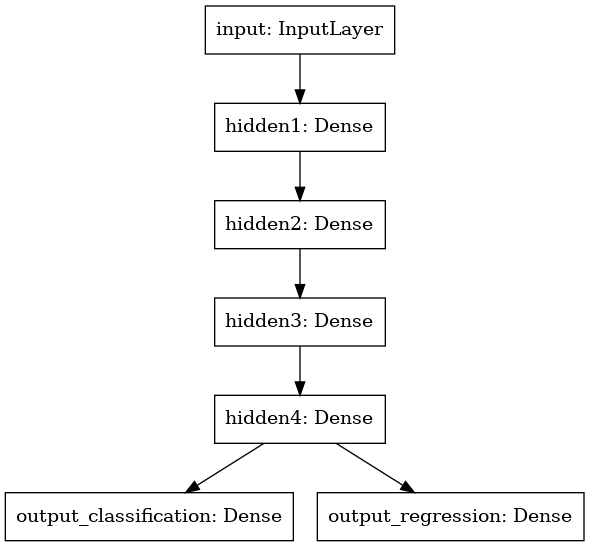

In [34]:
# to save it use this parameter to_file="model_name.png",
from tensorflow.keras.utils import plot_model
plot_model(model)

In [15]:
early_stop = EarlyStopping(monitor='val_loss', patience=6, mode='min')
log_csv = CSVLogger("train_val_logs.csv", separator=',', append=False)
callbacks=[log_csv]

In [16]:
history = model.fit(X_train, [y_class_train, y_reg_train], 
                   epochs=200,verbose=0,
                   validation_data=(X_test, [y_class_test, y_reg_test]))

2023-02-11 07:15:58.185669: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200
15/15 [==============================] - 2s 28ms/step - loss: 558675.7500 - output_classification_loss: 0.6958 - output_regression_loss: 558675.1250 - output_classification_accuracy: 0.3802 - output_regression_accuracy: 0.0000e+00 - val_loss: 526748.7500 - val_output_classification_loss: 0.6896 - val_output_regression_loss: 526748.0000 - val_output_classification_accuracy: 0.4035 - val_output_regression_accuracy: 0.0000e+00
Epoch 2/200
15/15 [==============================] - 0s 6ms/step - loss: 557740.2500 - output_classification_loss: 0.6892 - output_regression_loss: 557739.5625 - output_classification_accuracy: 0.3934 - output_regression_accuracy: 0.0000e+00 - val_loss: 525245.6250 - val_output_classification_loss: 0.6883 - val_output_regression_loss: 525245.0000 - val_output_classification_accuracy: 0.3772 - val_output_regression_accuracy: 0.0000e+00
Epoch 3/200
15/15 [==============================] - 0s 6ms/step - loss: 555147.3125 - output_classification_loss: 0.6981

## Prediction for classification and regression

In [17]:
y_class_pred, y_reg_pred = model.predict(X_test)
y_class_pred = np.round(y_class_pred)

## Performance evaluation for classification

In [18]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
print(classification_report(y_class_test,y_class_pred))

              precision    recall  f1-score   support

           0       0.85      1.00      0.92        71
           1       1.00      0.70      0.82        43

    accuracy                           0.89       114
   macro avg       0.92      0.85      0.87       114
weighted avg       0.90      0.89      0.88       114



In [19]:
print(accuracy_score(y_class_test,y_class_pred))

0.8859649122807017


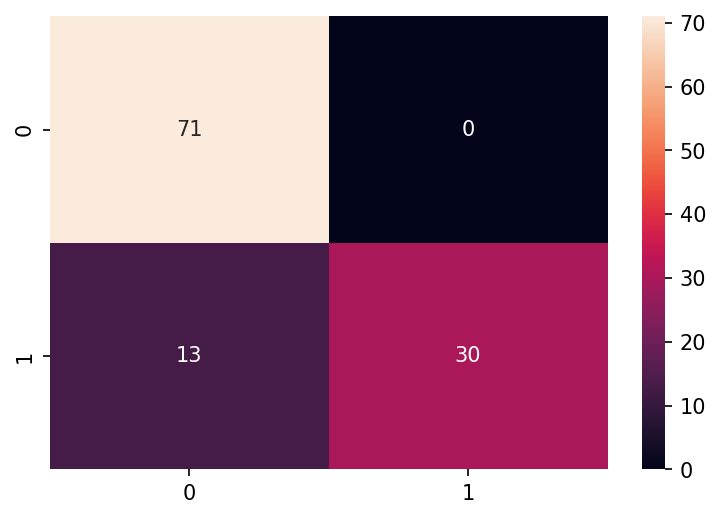

In [29]:
cn_mt = confusion_matrix(y_class_test,y_class_pred)
sns.heatmap(cn_mt, annot=True, fmt='g')
plt.show()

## Perfromance evaluation for regression

In [21]:
from sklearn.metrics import r2_score, mean_squared_error
print(mean_squared_error(y_reg_test,y_reg_pred,squared = False))

26.017815642493492


In [22]:
print(r2_score(y_reg_test,y_reg_pred))

0.9935793948797418


In [23]:
history.history.keys()

dict_keys(['loss', 'output_classification_loss', 'output_regression_loss', 'output_classification_accuracy', 'output_regression_accuracy', 'val_loss', 'val_output_classification_loss', 'val_output_regression_loss', 'val_output_classification_accuracy', 'val_output_regression_accuracy'])

## Learning Curve for classification

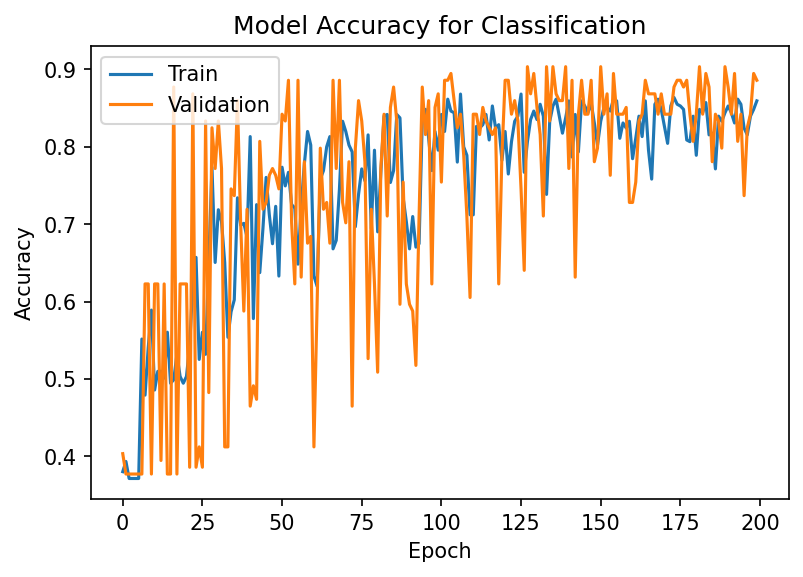

In [30]:
## Learning Curve for classification
plt.plot(history.history['output_classification_accuracy'])
plt.plot(history.history['val_output_classification_accuracy'])
plt.title('Model Accuracy for Classification')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

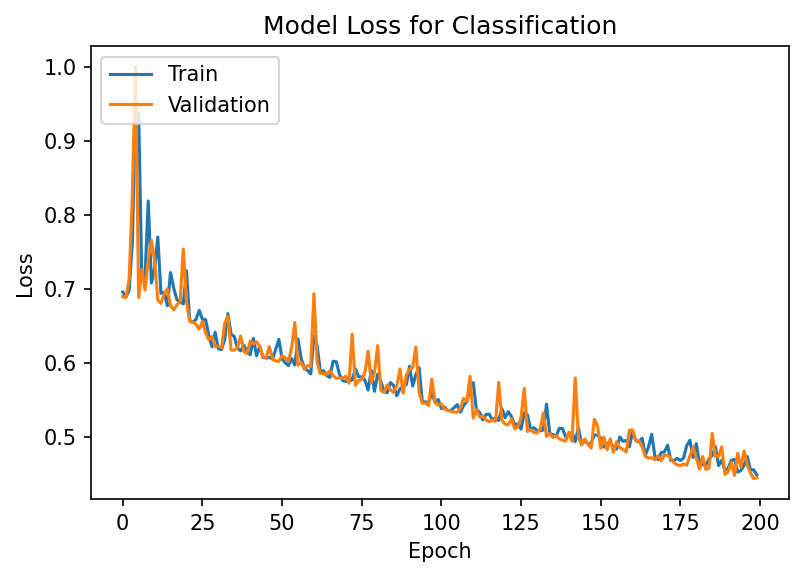

In [31]:
## Learning Curve for classification
plt.plot(history.history['output_classification_loss'])
plt.plot(history.history['val_output_classification_loss'])
plt.title('Model Loss for Classification')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Learning Curve for Regression

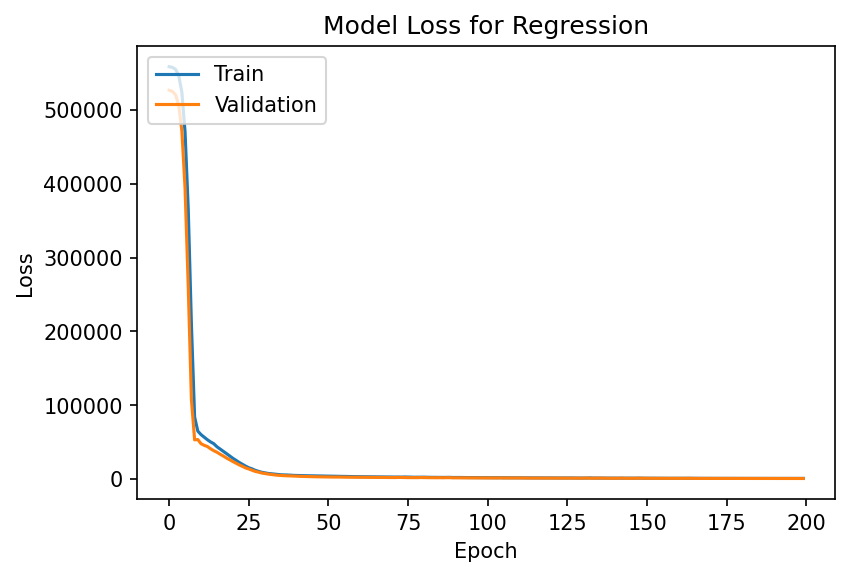

In [32]:
## Learning Curve for classification
plt.plot(history.history['output_regression_loss'])
plt.plot(history.history['val_output_regression_loss'])
plt.title('Model Loss for Regression')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()